In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [463]:
# def get_alibi_mat(seq_len=10, n_heads=10, dtype=torch.float, device='cpu'):
#     a = torch.stack([torch.arange(i, i+seq_len, dtype=dtype, device=device) for i in range(0, -seq_len, -1)])
#     m = 2.**(-8./n_heads)
#     m = 1.
#     m = m**torch.arange(1, n_heads+1, dtype=dtype, device=device)
#     a = m[:, None, None]*a
#     return a

def get_alibi_mat(seq_len=10, n_heads=10, dtype=torch.float, device='cpu'):
    a = torch.stack([torch.arange(i, i+seq_len, dtype=dtype, device=device) for i in range(0, -seq_len, -1)])
    m = 2.**(-8./n_heads)
    m = 1.
    m = m**torch.arange(1, n_heads+1, dtype=dtype, device=device)
    a = m[:, None, None]*a
    return a

def get_mask(attn, alibi=None, mask='full'):
    _, bs, nx, ny = attn.shape # output, input
    if mask == 'full':
        mask = torch.ones(bs, nx, ny, dtype=bool, device=attn.device)
    if mask == 'causal':
        mask = ~torch.tril(torch.ones(nx, ny, dtype=bool, device=attn.device), diagonal=ny-nx)
    if mask == 'doublecausal':
        # cross attention but don't attend to stuff ahead in the other seq
        ny = nx
        mask = ~torch.tril(torch.ones(nx, ny, dtype=bool, device=attn.device), diagonal=ny-nx)
        mask = torch.cat([mask, mask], dim=-1)

# plt.imshow(get_alibi_mat(32, 8)[1])
# plt.colorbar()
get_alibi_mat(8, 1)

tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
         [-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.],
         [-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
         [-3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
         [-4., -3., -2., -1.,  0.,  1.,  2.,  3.],
         [-5., -4., -3., -2., -1.,  0.,  1.,  2.],
         [-6., -5., -4., -3., -2., -1.,  0.,  1.],
         [-7., -6., -5., -4., -3., -2., -1.,  0.]]])

In [3]:
ids_book = parser.book2ids()

In [4]:
ds_train, ds_test = dataset.load_dataset(tqdm=tqdm)

Found existing dataset at ../data/datasets.pkl


In [88]:
def graph_it(net, ds=ds_train, n_batches=10, batch_size=32, seq_len=256, device='cpu'):
    net.to(device)
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    
    losses = []
    
    for batch in tqdm(dataset.get_random_batches(ds, n_batches, batch_size=batch_size, seq_len=seq_len), total=n_batches):
        batch = batch.to(device).long()
        inputs, targets = batch[:, :-1], batch[:, 1:]
        logits, _ = net.forward(inputs)
        
        # targets = targets[:, -logits.size(1) :]
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), targets.reshape(-1)).reshape(batch_size, seq_len-1)
        
        losses.append(loss.detach().mean(dim=0).cpu())
    losses = torch.stack(losses).mean(dim=0).detach().cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(losses, color='r')
    ax.tick_params(axis='y', labelcolor='r')
    ax2 = ax.twinx()
    ax2.plot(np.exp(losses), color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    ax.set_xlabel('Output token position');ax.set_ylabel('Loss');ax2.set_ylabel('Perplexity')
    plt.show()
    return losses


In [89]:
config_net = longrange.get_config("transformer")
print(config_net)
net = longrange.LongRangeGPT(**config_net)
util.count_params(net)

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 6, 'n_head': 6, 'n_embd': 384, 'n_latent_tokens': None, 'use_memory': False, 'share_cr': False, 'memory_cross_attn_only': True}


10745856

In [90]:
batch_size, seq_len, seq_len_test = 64, 15, 25

  0%|          | 0/800 [00:00<?, ?it/s]

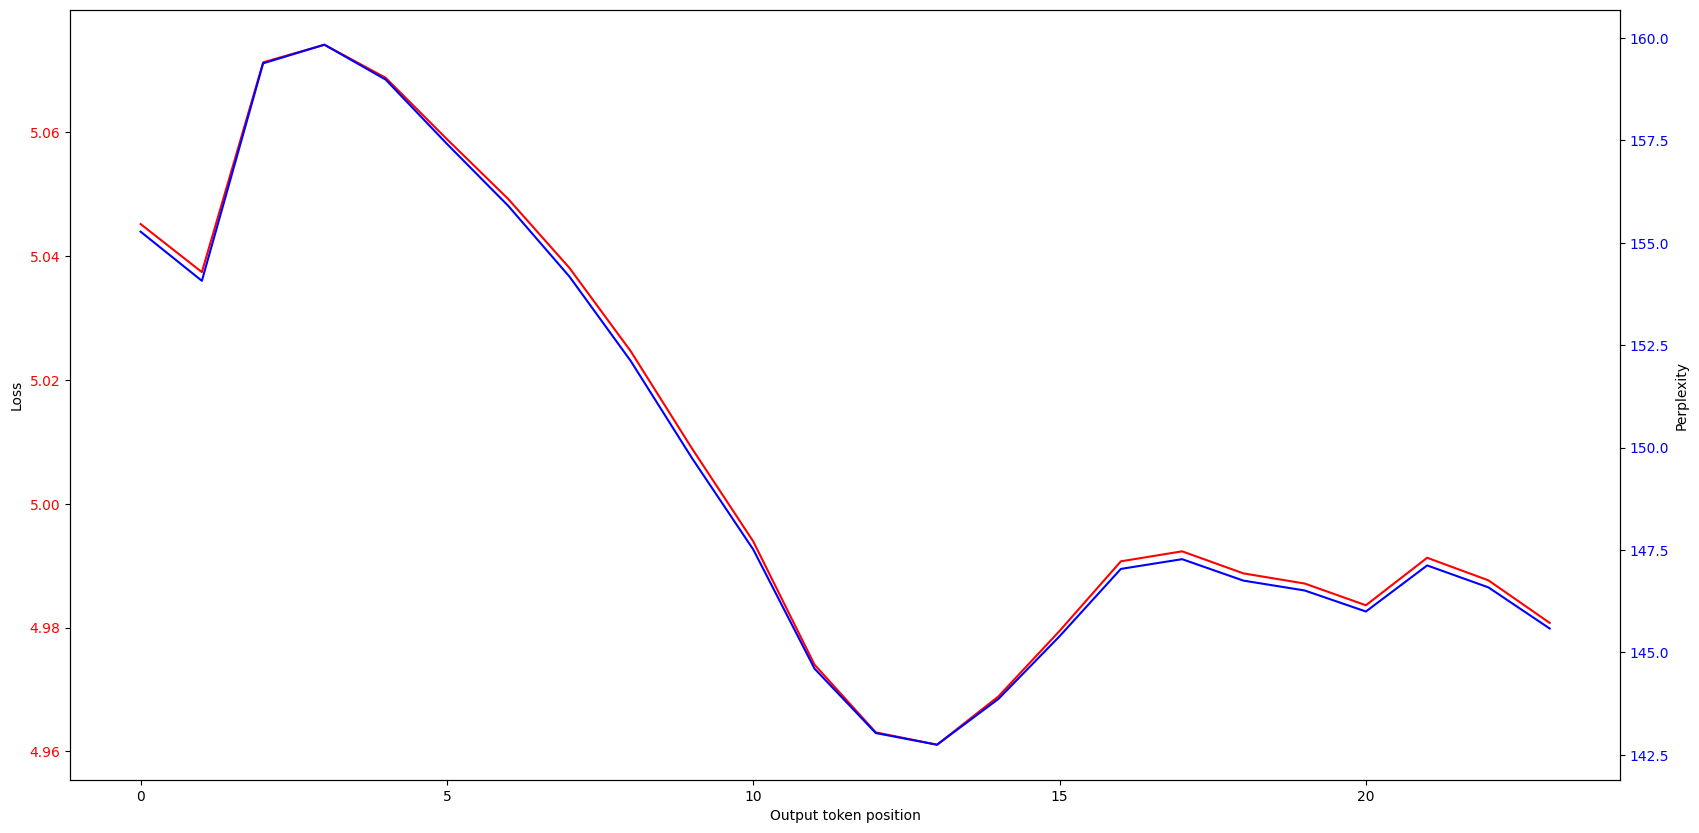

In [91]:
net.eval()
losses = graph_it(net, n_batches=800, batch_size=batch_size, seq_len=seq_len_test, device='cuda:1');

In [92]:
net.train()
train.train_transformer(ds_train, net, n_batches=4000, batch_size=batch_size, seq_len=seq_len, lr=1e-3, device='cuda:1', tqdm=tqdm)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

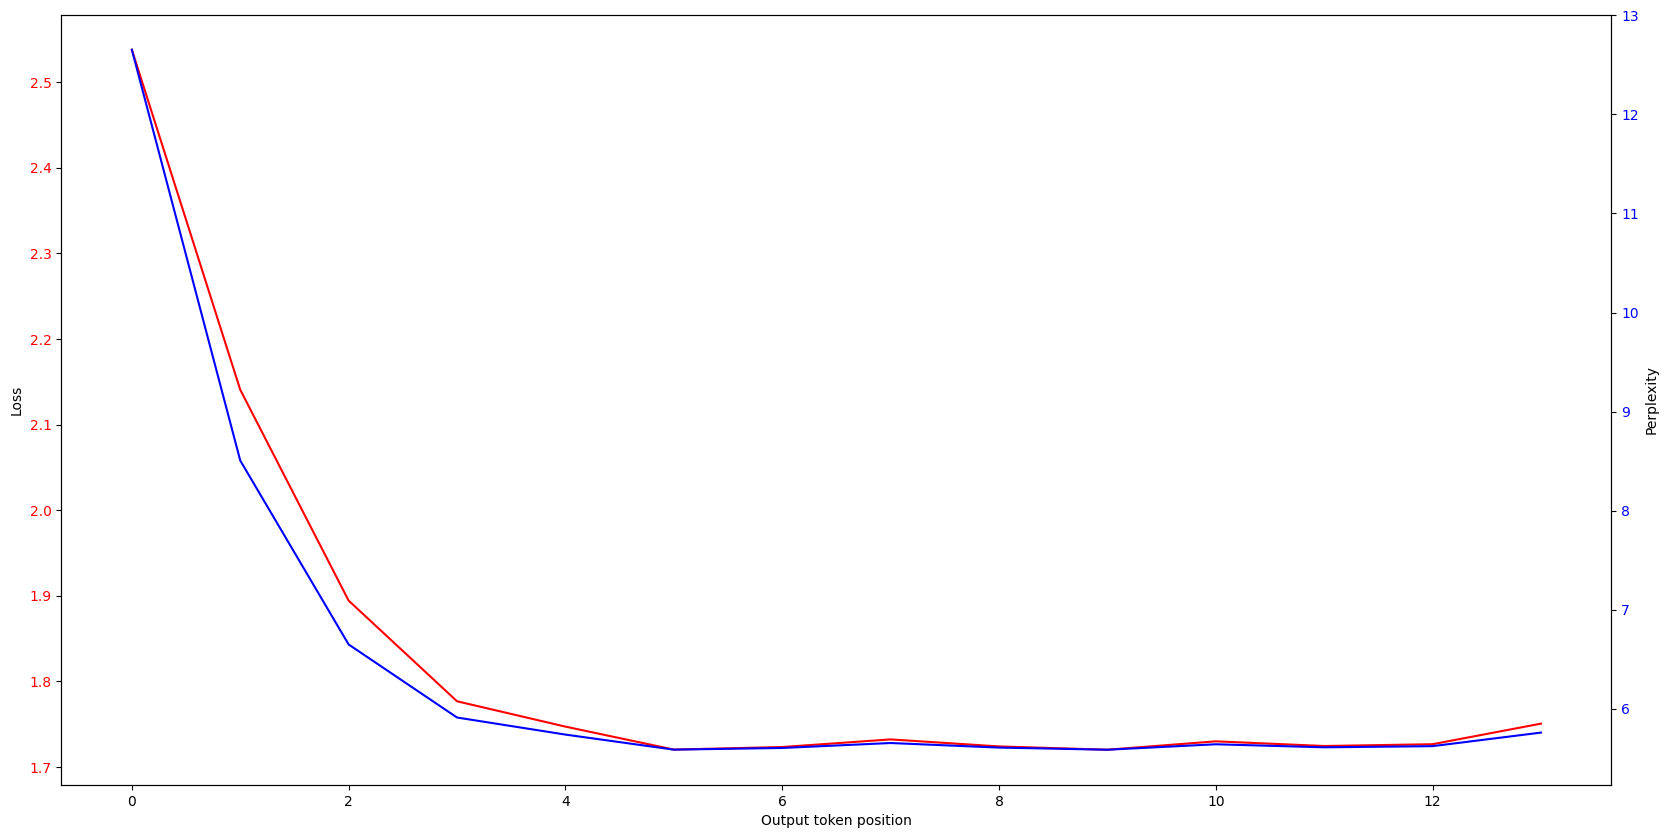

In [95]:
net.eval()
losses = graph_it(net, n_batches=800, batch_size=batch_size, seq_len=seq_len, device='cuda:1');

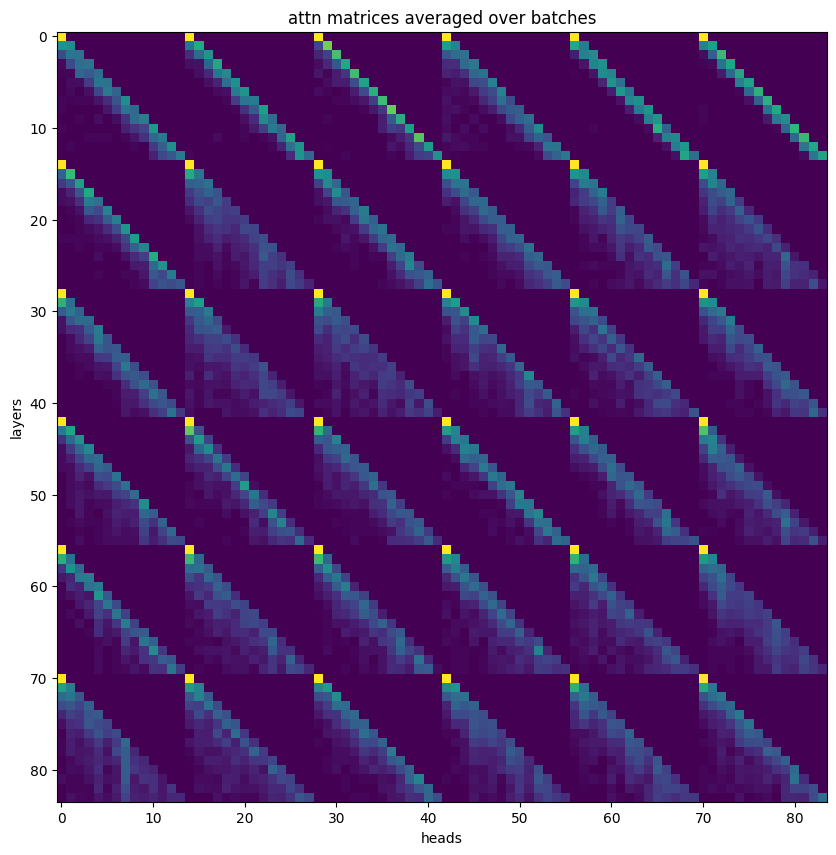

In [104]:
a = torch.stack([block.mhattn.attn_mat.mean(dim=0) for block in net.blocks_main])
# a = torch.stack([block.mhattn.attn_mat.max(dim=0).values for block in net.blocks_main])
# a = torch.stack([block.mhattn.attn_mask for block in net.blocks_main])
a = rearrange(a, 'l h y x -> (l y) (h x)')
plt.figure(figsize=(10, 10))
plt.imshow(a.detach().cpu().numpy())
plt.title('attn matrices averaged over batches');plt.ylabel('layers'); plt.xlabel('heads')
plt.show()

In [110]:
for a in parser.ids2text(net.ids):
    display(a)

'urn your head:'

'ce streamed fr'

'just about col'

' leader and hi'

'ty and abstrac'

'But a person c'

'nct species an'

'as Christ kept'

' saw the headi'

' for consideri'

'h mule\ntranspo'

't in the Sky i'

't interrupted.'

'of their bandb'

' have no secre'

'hat though we '

'\nwill smell of'

'go.\nMeanwhile,'

'ive?" asked Ki'

's its source s'

"d. You're wond"

' the ground.\n"'

'\n Men ran upon'

'rk insisted on'

't my poor agit'

'ith a young wo'

'wung in rhythm'

' much hard wor'

'd that I liste'

'aw that\nthey h'

'ls and peacock'

'said Mrs. Cris'

' freely avouch'

' and keep long'

'in his chair a'

'e beautiful th'

'during\ncontrac'

'er charms,\n Th'

'and the river '

'ns, and brazen'

'ctions I have '

'he cabin--\n"Li'

'saw all that, '

' on with.\nBy t'

'e _Pink Un_ an'

'oment, and the'

'ieur. The one '

'Complete Angle'

'ers will be mo'

'n there, and N'

'wo-thirds of e'

'tinction simpl'

'r heard of. An'

'ough\nhis guilt'

'ke that--not i'

'n favour\nof Mo'

'out quitting t'

'us capybara).\n'

'"Women an\' pri'

'e, and now the'

'st words smote'

' till he confe'

'ng mass which '

'r perfect sava'

  0%|          | 0/200 [00:00<?, ?it/s]

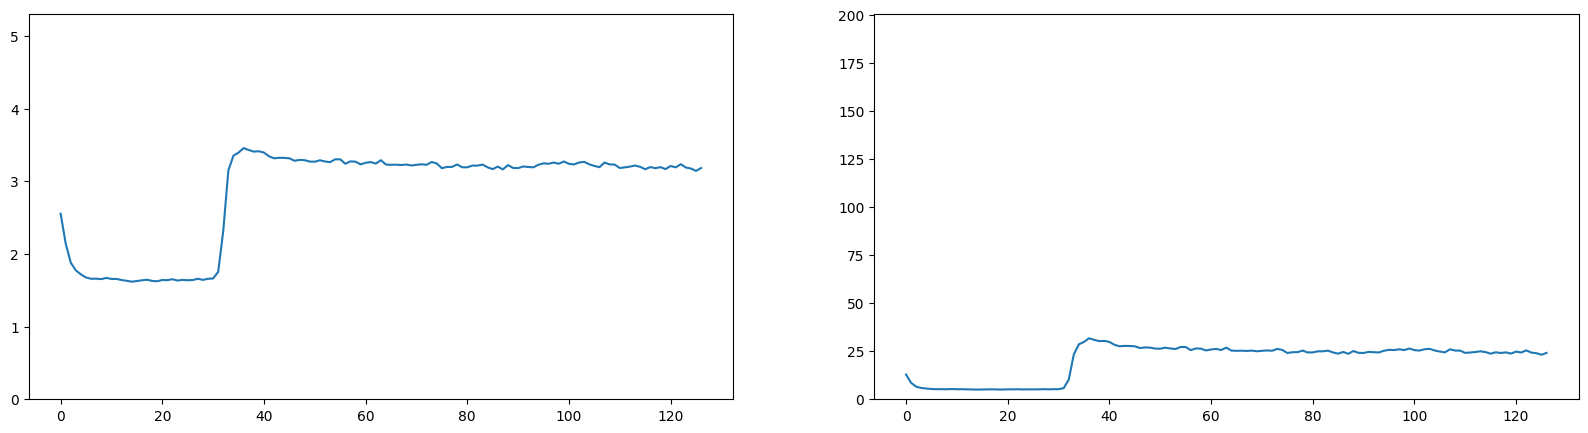

In [41]:
net.train()
losses = graph_it(net, n_batches=200, batch_size=batch_size, seq_len=seq_len*4, device='cuda:1');

In [43]:
losses[:32].mean()

1.707231

In [85]:
for a, b in dataset.get_random_batches_new(ds_train, 1, 1, 100, 10, min_dist=1, max_dist=2, unbind=False):
    # print(a.shape, b.shape)
    print('|'.join([parser.ids2text(ai) for ai in a[0]]))

e, I could|do
nothing|more to ke|p out the |empest. I |ound, in p|shing at t|e leaf of
|he shutter| that the |ind resist|d, more as|if it had |een a ston| wall
or a|mass of ir|n, than a |ere curren| of air. T|ere were o|e or two
p|ople outsi|e trying t| fasten th| windows, |nd I went |ut to help| but
we ha| no tools |t hand: on| man was b|own down t|e hill in |ront of th|
house, be|ore my fac|; and the |ther and m|self had g|eat diffic|lty in
get|ing back a|ain inside|the door. |he rain on|my face an| hands fel|
like so m|ch small s|ot from a |un. There |as great e|ertion nec|ssary
to s|ut the doo| of the ho|se.
"The w|ndows at t|e end of t|e large ro|m were now|giving way| and I
sup|ose it was|about nine|o'clock, w|en the hur|icane burs| them in, |s
if it ha| been a di|charge fro| a battery|of heavy c|nnon. The |hutters
we|e first fo|ced open, |nd the win| fastened |hem back t| the wall;|and then t|e panes of|glass were|smashed by|the mere f|rce of the|gale,
with|ut anythin| having to

In [6]:
import evaluate

In [35]:
def plot_results(losses, fbin2loss):
    def str_loss(a):
        return f'{a: 10.5f} (={np.exp(a): 10.5f} ppl)'
        
    print(f'       Overall loss: {str_loss(losses.mean().item())}')
    print(f'Final Sequence loss: {str_loss(losses[-1].mean().item())}')
    
    # plt.plot()
    
    print(fbin2loss)
    print(losses.shape)
    
    for i, lossesi in list(enumerate(losses)):
        plt.plot(lossesi.exp(), label=f'Sequence {i}')
    plt.xlabel('Sequence'); plt.ylabel('PPL')
    # plt.ylim(0, 160)
    plt.legend()
    plt.show()
    


In [387]:
config_net = longrange.get_config("transformer")
print(config_net)
net = longrange.LongRangeGPT(**config_net)
util.count_params(net)

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 6, 'n_head': 6, 'n_embd': 384, 'n_latent_tokens': None, 'use_memory': False, 'share_cr': False, 'memory_cross_attn_only': True}


10745856

  0%|          | 0/100 [00:00<?, ?it/s]

       Overall loss:    5.04321 (= 154.96696 ppl)
Final Sequence loss:    5.04321 (= 154.96696 ppl)
{-2: tensor([5.0698]), -1: tensor([nan]), 0: tensor([4.8418]), 1: tensor([4.8610]), 2: tensor([5.1129]), 3: tensor([4.9562]), 4: tensor([4.8689]), 5: tensor([4.9119]), 6: tensor([4.9104]), 7: tensor([4.8692]), 8: tensor([4.9104])}
torch.Size([1, 31])


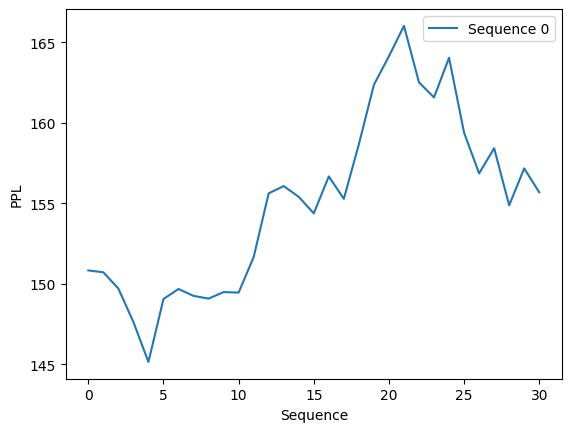

In [390]:
losses, fbin2loss = evaluate.evaluate_longrange(ds_test, net, 100, 32, 1, 32, 'cuda:0', tqdm=tqdm)
plot_results(losses, fbin2loss)

In [391]:
train.train_transformer(ds_train, net, n_batches=2000, batch_size=32, seq_len=32, lr=1e-3, tqdm=tqdm, device='cuda:0')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

       Overall loss:    2.91286 (=  18.40945 ppl)
Final Sequence loss:    2.91286 (=  18.40945 ppl)
{-2: tensor([2.8121]), -1: tensor([nan]), 0: tensor([2.4402]), 1: tensor([3.2959]), 2: tensor([3.3343]), 3: tensor([3.4133]), 4: tensor([3.5760]), 5: tensor([3.6750]), 6: tensor([3.6632]), 7: tensor([3.7154]), 8: tensor([3.8952])}
torch.Size([1, 127])


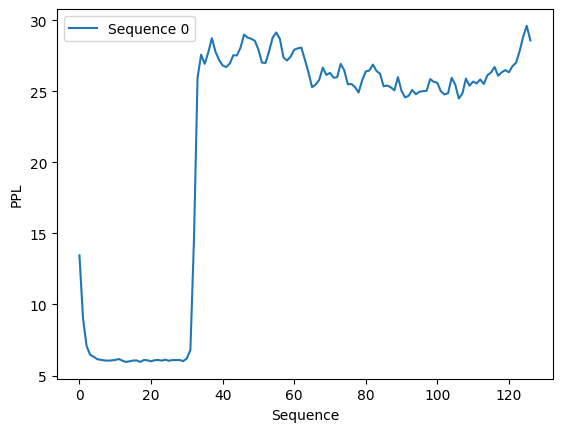

In [392]:
losses, fbin2loss = evaluate.evaluate_longrange(ds_test, net, 1000, 32, 1, 128, 'cuda:0', tqdm=tqdm)
plot_results(losses, fbin2loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

       Overall loss:    2.77501 (=  16.03871 ppl)
Final Sequence loss:    2.77501 (=  16.03871 ppl)
{-2: tensor([2.6715]), -1: tensor([nan]), 0: tensor([2.3704]), 1: tensor([3.0573]), 2: tensor([3.0875]), 3: tensor([3.3596]), 4: tensor([3.5332]), 5: tensor([3.5525]), 6: tensor([3.6050]), 7: tensor([3.6418]), 8: tensor([3.8262])}
torch.Size([1, 127])


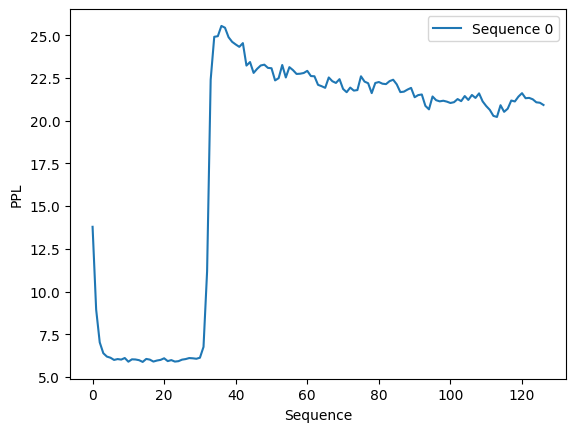

In [383]:
losses, fbin2loss = evaluate.evaluate_longrange(ds_test, net, 1000, 32, 1, 128, 'cuda:0', tqdm=tqdm)
plot_results(losses, fbin2loss)

In [82]:
config_net = longrange.get_config("longrange1")
print(config_net)
net = longrange.LongRangeGPT(**config_net)
util.count_params(net)

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 6, 'n_head': 6, 'n_embd': 384, 'n_latent_tokens': None, 'use_memory': True, 'share_cr': False}


21392640

  0%|          | 0/100 [00:00<?, ?it/s]

       Overall loss:    5.06463 (= 158.32171 ppl)
Final Sequence loss:    5.06506 (= 158.39034 ppl)
{-2: tensor([5.0804, 5.0901, 5.0884, 5.0861]), -1: tensor([nan, nan, nan, nan]), 0: tensor([4.9464, 4.9869, 4.9828, 4.9872]), 1: tensor([5.0782, 5.1018, 5.0922, 5.0887]), 2: tensor([4.9860, 4.9834, 4.9872, 5.0054]), 3: tensor([4.8957, 4.8767, 4.9049, 4.8814]), 4: tensor([4.9596, 4.9496, 4.9472, 4.9563]), 5: tensor([4.9388, 4.9240, 4.9393, 4.9278]), 6: tensor([4.8975, 4.8842, 4.8877, 4.8961]), 7: tensor([4.9556, 4.9350, 4.9343, 4.9215]), 8: tensor([4.9530, 4.9352, 4.9538, 4.9472])}
torch.Size([4, 31])


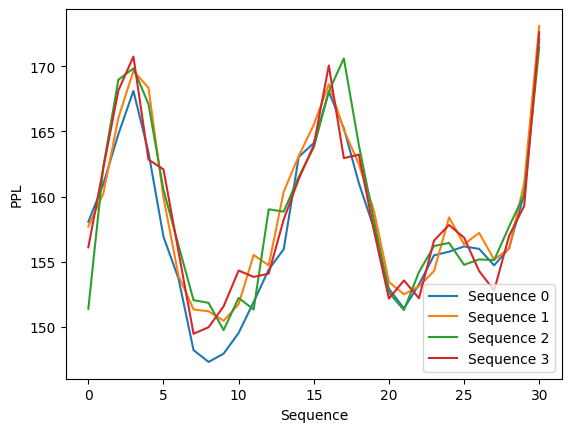

In [83]:
losses, fbin2loss = evaluate.evaluate_longrange(ds_test, net, 100, 32, 4, 32, 'cuda:0', tqdm=tqdm)
plot_results(losses, fbin2loss)

In [84]:
train.train_longrange(ds_test, net, n_batches=1000, batch_size=32, seq_len=32, lr=1e-3, tqdm=tqdm, device='cuda:0')

  0%|          | 0/1000 [00:00<?, ?it/s]

Main blocks gradient mag:
 6.945e-01  6.168e-01  6.063e-01  6.069e-01  5.868e-01  6.062e-01 
Memory Retrieval blocks gradient mag:
 4.302e-02  3.914e-02  4.220e-02  3.756e-02 
Memory Creator blocks gradient mag:
 1.248e-02  1.213e-02 
Main blocks gradient mag:
 7.952e-02  3.169e-02  2.733e-02  3.214e-02  4.621e-02  5.125e-02 
Memory Retrieval blocks gradient mag:
 2.229e-04  3.224e-04  4.669e-04  5.305e-04 
Memory Creator blocks gradient mag:
 2.183e-05  2.759e-05 
Main blocks gradient mag:
 8.785e-02  3.621e-02  2.336e-02  2.501e-02  2.998e-02  3.601e-02 
Memory Retrieval blocks gradient mag:
 2.277e-04  3.150e-04  4.861e-04  5.788e-04 
Memory Creator blocks gradient mag:
 1.755e-05  2.194e-05 
Main blocks gradient mag:
 1.041e-01  4.017e-02  2.661e-02  2.609e-02  3.192e-02  3.824e-02 
Memory Retrieval blocks gradient mag:
 1.551e-04  2.129e-04  3.271e-04  3.846e-04 
Memory Creator blocks gradient mag:
 1.157e-05  1.399e-05 
Main blocks gradient mag:
 9.761e-02  3.685e-02  2.637e-02  

  0%|          | 0/1000 [00:00<?, ?it/s]

       Overall loss:    1.80636 (=   6.08825 ppl)
Final Sequence loss:    1.80654 (=   6.08933 ppl)
{-2: tensor([1.5534, 1.5494, 1.5503, 1.5522]), -1: tensor([nan, nan, nan, nan]), 0: tensor([1.7953, 1.8038, 1.7938, 1.7914]), 1: tensor([2.9326, 2.9282, 2.9208, 2.9166]), 2: tensor([2.7438, 2.7469, 2.7532, 2.7447]), 3: tensor([2.9045, 2.9010, 2.9016, 2.9135]), 4: tensor([3.3104, 3.3151, 3.3111, 3.3061]), 5: tensor([3.3880, 3.3742, 3.3697, 3.3854]), 6: tensor([3.4241, 3.4358, 3.4531, 3.4401]), 7: tensor([3.4369, 3.4214, 3.4302, 3.4258]), 8: tensor([3.6563, 3.6472, 3.6372, 3.6387])}
torch.Size([4, 31])


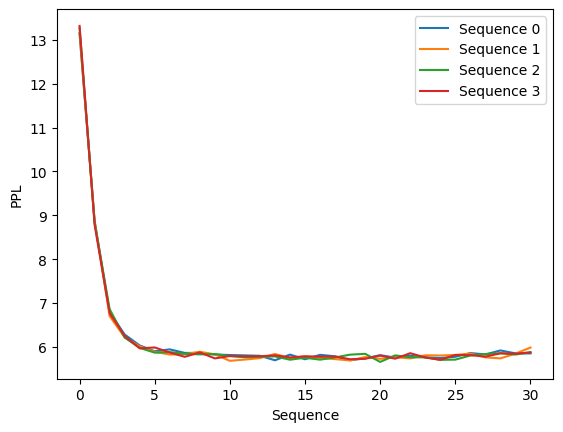

In [85]:
# losses, fbin2loss = evaluate.evaluate_longrange(ds_test, net, 100, 32, 1, 32, 'cuda:0', tqdm=tqdm)
losses, fbin2loss = evaluate.evaluate_longrange(ds_test, net, 1000, 32, 4, 32, 'cuda:0', tqdm=tqdm)
plot_results(losses, fbin2loss)

In [ ]:
{-2: tensor([1.6713]), -1: tensor([nan]), 0: tensor([1.8283]), 1: tensor([2.9665]), 2: tensor([2.8010]), 3: tensor([3.0208]), 4: tensor([3.3380]), 5: tensor([3.4841]), 6: tensor([3.4799]), 7: tensor([3.4865]), 8: tensor([3.6878])}


In [ ]:
{-2: tensor([1.5546, 1.5561, 1.5576, 1.5553]), -1: tensor([nan, nan, nan, nan]), 0: tensor([1.8841, 1.8920, 1.8888, 1.8863]), 1: tensor([2.7659, 2.7749, 2.7650, 2.7610]), 2: tensor([2.7370, 2.7459, 2.7400, 2.7481]), 3: tensor([2.9723, 2.9491, 2.9722, 2.9459]), 4: tensor([3.3202, 3.3093, 3.3003, 3.3137]), 5: tensor([3.3980, 3.4042, 3.4164, 3.3949]), 6: tensor([3.4233, 3.4272, 3.4284, 3.4265]), 7: tensor([3.4171, 3.4115, 3.4232, 3.4231]), 8: tensor([3.6213, 3.6231, 3.6332, 3.6324])}


In [359]:
np.sum([len(value['ids'])for value in ds_train.values()])

939254126

In [360]:
939254126/1e6

939.254126

In [344]:
np.random.seed(0); torch.manual_seed(0)
config_net = longrange.get_config("longrange3")
print(config_net)
net = longrange.LongRangeGPT(**config_net)
util.count_params(net)

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 6, 'n_head': 6, 'n_embd': 384, 'n_latent_tokens': None, 'use_memory': True, 'share_cr': False, 'memory_cross_attn_only': False}


21392640

  0%|          | 0/100 [00:00<?, ?it/s]

       Overall loss:    5.02639 (= 152.38229 ppl)
Final Sequence loss:    5.02279 (= 151.83505 ppl)
{-2: tensor([5.0511, 5.0372, 5.0341, 5.0344]), -1: tensor([nan, nan, nan, nan]), 0: tensor([4.7567, 4.7105, 4.7095, 4.7346]), 1: tensor([5.0948, 5.0853, 5.0730, 5.0716]), 2: tensor([5.0418, 5.0485, 5.0455, 5.0250]), 3: tensor([5.0200, 5.0359, 5.0248, 5.0269]), 4: tensor([4.9476, 4.9380, 4.9325, 4.9507]), 5: tensor([4.9884, 4.9985, 4.9839, 5.0000]), 6: tensor([4.9927, 5.0098, 4.9812, 5.0201]), 7: tensor([4.9556, 4.9869, 4.9720, 4.9855]), 8: tensor([5.0159, 4.9967, 5.0110, 5.0219])}
torch.Size([4, 31])


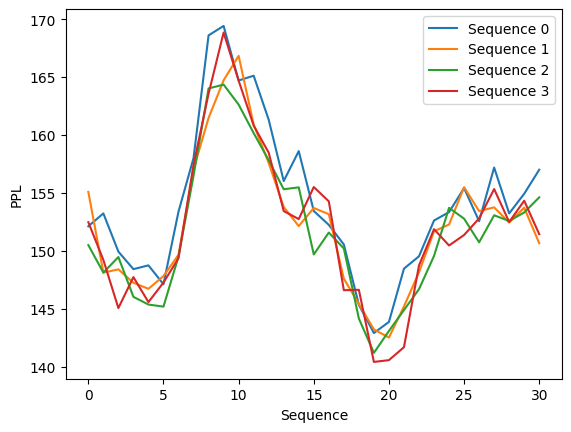

In [345]:
losses, fbin2loss = evaluate.evaluate_longrange(ds_test, net, 100, 32, 4, 32, 'cuda:1', tqdm=tqdm)
plot_results(losses, fbin2loss)

In [346]:
akl = train.train_longrange(ds_test, net, n_batches=100, batch_size=32, seq_len=32, lr=1e-3, tqdm=tqdm, device='cuda:0')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

       Overall loss:    2.36043 (=  10.59554 ppl)
Final Sequence loss:    2.35988 (=  10.58963 ppl)
{-2: tensor([2.1932, 2.1929, 2.1909, 2.1920]), -1: tensor([nan, nan, nan, nan]), 0: tensor([2.1564, 2.1583, 2.1630, 2.1570]), 1: tensor([3.0330, 3.0339, 3.0368, 3.0296]), 2: tensor([2.9049, 2.9098, 2.9091, 2.9057]), 3: tensor([3.1660, 3.1628, 3.1675, 3.1630]), 4: tensor([3.4664, 3.4812, 3.4686, 3.4769]), 5: tensor([3.4784, 3.4741, 3.5080, 3.4850]), 6: tensor([3.5288, 3.5222, 3.5178, 3.5036]), 7: tensor([3.5378, 3.5310, 3.5585, 3.5287]), 8: tensor([3.7099, 3.7024, 3.6975, 3.7030])}
torch.Size([4, 31])


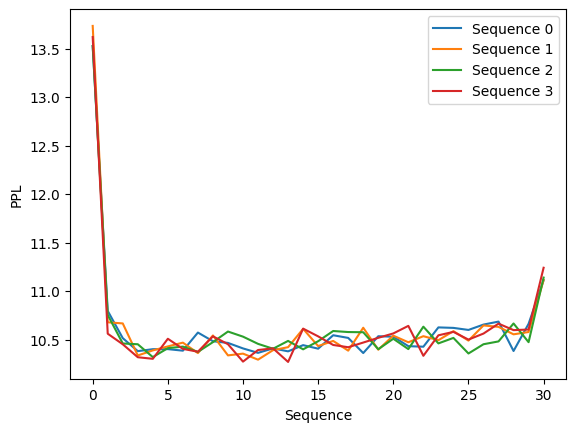

In [354]:
losses, fbin2loss = evaluate.evaluate_longrange(ds_test, net, 1000, 32, 4, 32, 'cuda:1', tqdm=tqdm)
plot_results(losses, fbin2loss)

In [348]:
data = akl.get_arrays()

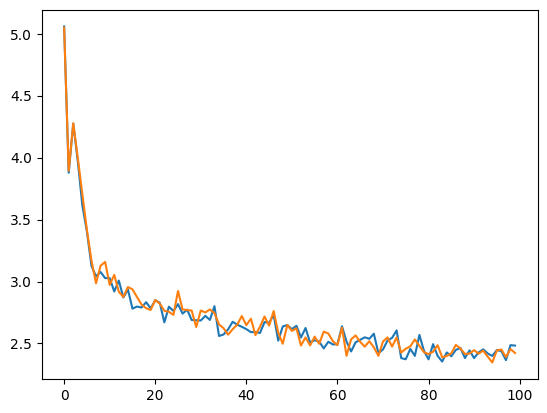

In [349]:
plt.plot(data['loss1'])
plt.plot(data['loss2'])

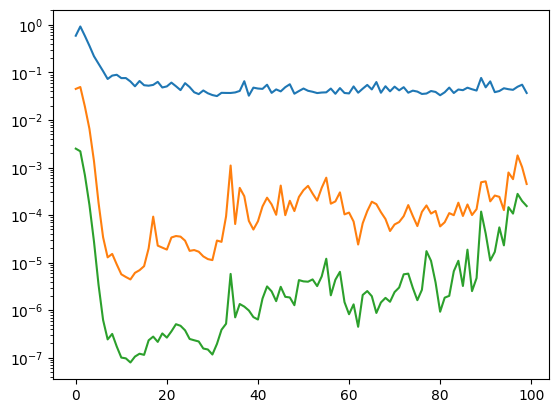

In [350]:
plt.yscale('log')
plt.plot(data['grad_blocks_main'].mean(axis=-1))
plt.plot(data['grad_blocks_retriever'].mean(axis=-1))
plt.plot(data['grad_blocks_creator'].mean(axis=-1))

In [351]:
akl.keys()

{'attn_mat_blocks_main.0',
 'attn_mat_blocks_main.1',
 'attn_mat_blocks_main.2',
 'attn_mat_blocks_main.3',
 'attn_mat_blocks_main.4',
 'attn_mat_blocks_main.5',
 'attn_mat_blocks_memory_creator.0',
 'attn_mat_blocks_memory_creator.1',
 'attn_mat_blocks_memory_retriever.0',
 'attn_mat_blocks_memory_retriever.1',
 'attn_mat_blocks_memory_retriever.2',
 'attn_mat_blocks_memory_retriever.3',
 'grad_blocks_creator',
 'grad_blocks_main',
 'grad_blocks_retriever',
 'loss',
 'loss1',
 'loss2'}

In [ ]:
plt.subplot(

In [355]:
a = akl.get_array('attn_mat_blocks_main.4', ret_ts=False)
# a = akl.get_array('attn_mat_blocks_memory_retriever.2', ret_ts=False)
a.shape

(5, 32, 6, 31, 62)

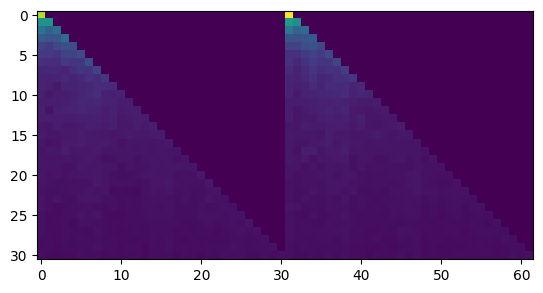

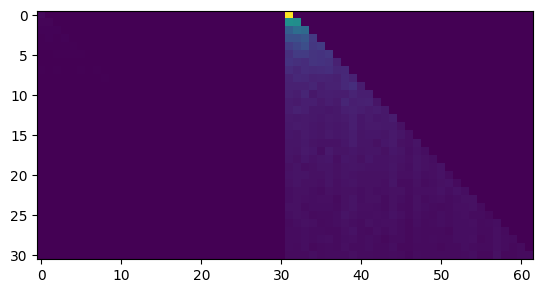

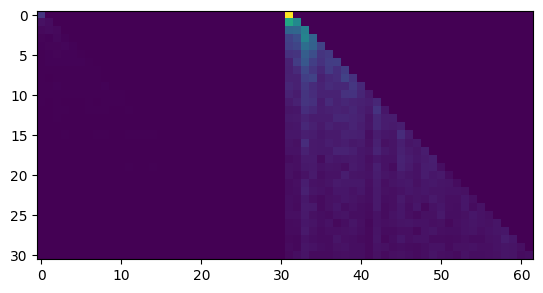

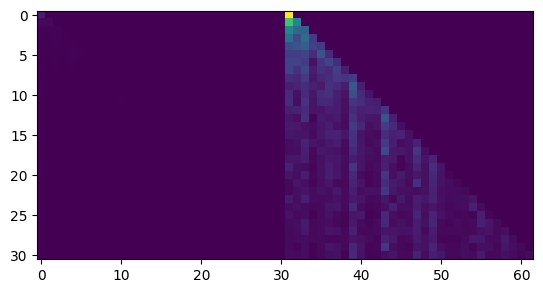

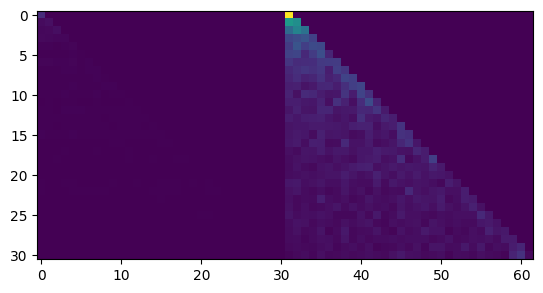

In [356]:
for ai in a.mean(axis=1):
    plt.imshow(ai[0])
    plt.show()

In [98]:
def test_dataset(ds):
    for batch_ids, batch_fbin in dataset.get_seq_batches(ds, 1, 1, n_seqs=5, seq_len=128, min_dist=0, max_dist=1, unbind=True):
        for a, b in zip(batch_ids, batch_fbin):
            display(parser.ids2text(a[0]).replace('\n',' '))
            c = ''.join([f'{i}' if i>=0 else (' ' if i==-2 else '?') for i in b[0].tolist()])
            display(c)
            print('---------------')
            
    for batch_ids, batch_fbin in dataset.get_seq_batches(ds, 1, 1000, n_seqs=5, seq_len=128, min_dist=0, max_dist=1, unbind=False):
        for fbin in batch_fbin.unique().tolist():
            freq = (batch_fbin==fbin).sum().item()/batch_fbin.numel()
            print(f'{freq*100: 10.05f}% of characters belong to {fbin=:3.0f}')
            
        # print(batch_ids.shape, batch_fbin.shape)
test_dataset(ds_train)

'inted, "It will be recollected"--and I\'ve noticed in my life, that it is sure to be printed that it _will_ be recollected, whene'

'        1  2    1  8             0   1 7  7       1  2  3     1    1  1  4    0  1  6       1    1   2     1  8            7    '

---------------


'ver it won\'t--"that Mr. Chops is the individual of small stature, whose brilliant success in the last State Lottery attracted so'

'    1  6   3   1    5   8     1  0   5          0  4     8        6     7         5       1  0   3    3     7       7         2 '

---------------


' much attention." Well, I says to myself, Such is Life! He has been and done it in earnest at last. He has astonished George the'

' 3    6           3     1 5    0  6       3    1  3     2  2   2    0   5    1  1  8       1  3     2  2   8          5      0  '

---------------


' Fourth! (On account of which, I had that canvass new-painted, him with a bag of money in his hand, a presentin it to George the'

' 6        1  4       0  2      1 2   1    8       2   7        3   1    0 6   0  4     1  2   4     0 ?         1  0  5      0  '

---------------


' Fourth, and a lady in Ostrich Feathers fallin in love with him in a bag-wig, sword, and buckles correct.) I took the House as i'

' 6       0   0 6    1  8       8        8      1  4    1    3   1  0 6   8    7      0   8       6         1 5    0   3     1  1'

---------------
  81.65781% of characters belong to fbin= -2
   0.14297% of characters belong to fbin= -1
   3.16266% of characters belong to fbin=  0
   2.70781% of characters belong to fbin=  1
   2.98344% of characters belong to fbin=  2
   1.75109% of characters belong to fbin=  3
   1.22734% of characters belong to fbin=  4
   1.44000% of characters belong to fbin=  5
   1.38906% of characters belong to fbin=  6
   1.68469% of characters belong to fbin=  7
   1.85312% of characters belong to fbin=  8


  0%|          | 0/200 [00:00<?, ?it/s]

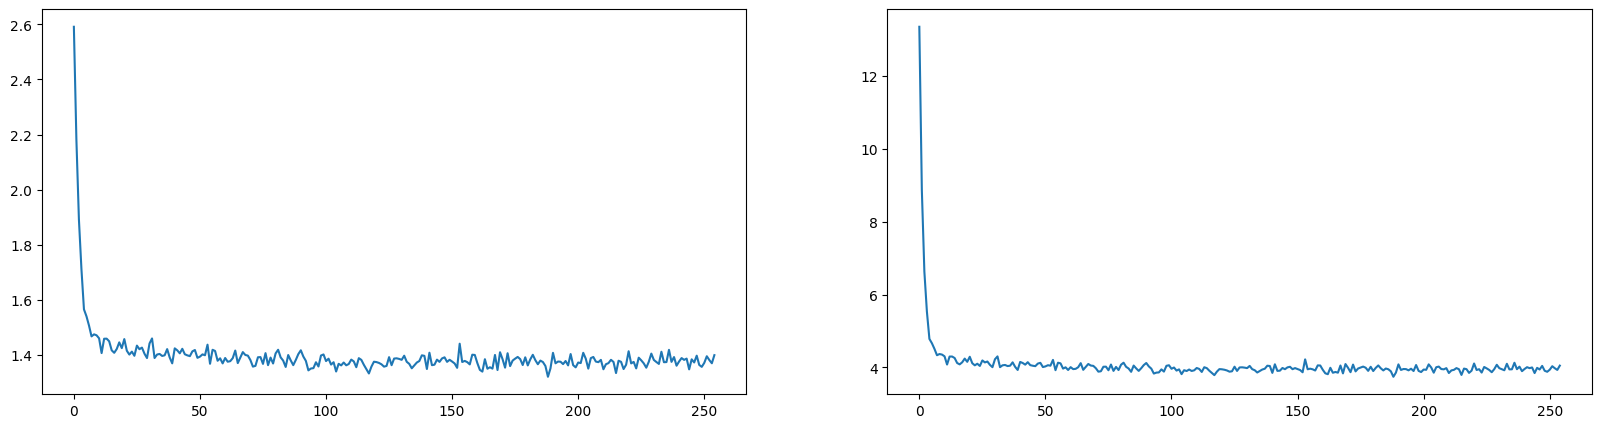

In [128]:
graph_it(net, n_batches=200, device='cuda:1');

In [137]:
ids = parser.text2ids('And then the king said ')[None].to('cuda:1').long()
net.eval()
ids = longrange.generate_ak(net, ids, n_tokens=1000, max_context_length=256, do_sample=True)[0]

In [138]:
parser.ids2text(ids)

'And then the king said of\nlate. I reply when I would have had to you."\n\n"\'You be in that order now, I hadn\'t shall over it away at me.\nShe caught it dome put out on a fightly country.\n\nBazzeth\'s appared with a; he said: "Well, then. I had say if you that\ncountry excuted as first a foreign: and as it aslight she did is\nwolding you?"\n\nhe punished.\n\n\n"Truntly you say for that."\n\n"Colloset she would nyielder than breautter have turn her equally before\nKenty Wats," thought, brandled.\n\n\nIt but she ome will have beeen return his word of somebody, as a shower\nwearing to the roof suddden in Krench. The one whoever was so quite\ngradually. "Come it hope bee to express he will play just having to also\nfutture to recile it. Well-par\'---thought here, and did you say?"\nreported. "It\'s all," I contemported, shaking at haffird---it gravely.\nHe would do like a livifly?"\n\n"The truth fighter. Let us the hollers I came a hours to help wyour\nparty of this transplem to Liprim

In [139]:
print(parser.ids2text(ids))

And then the king said of
late. I reply when I would have had to you."

"'You be in that order now, I hadn't shall over it away at me.
She caught it dome put out on a fightly country.

Bazzeth's appared with a; he said: "Well, then. I had say if you that
country excuted as first a foreign: and as it aslight she did is
wolding you?"

he punished.


"Truntly you say for that."

"Colloset she would nyielder than breautter have turn her equally before
Kenty Wats," thought, brandled.


It but she ome will have beeen return his word of somebody, as a shower
wearing to the roof suddden in Krench. The one whoever was so quite
gradually. "Come it hope bee to express he will play just having to also
futture to recile it. Well-par'---thought here, and did you say?"
reported. "It's all," I contemported, shaking at haffird---it gravely.
He would do like a livifly?"

"The truth fighter. Let us the hollers I came a hours to help wyour
party of this transplem to Liprimate Brackey's, whosever send to t

  0%|          | 0/200 [00:00<?, ?it/s]

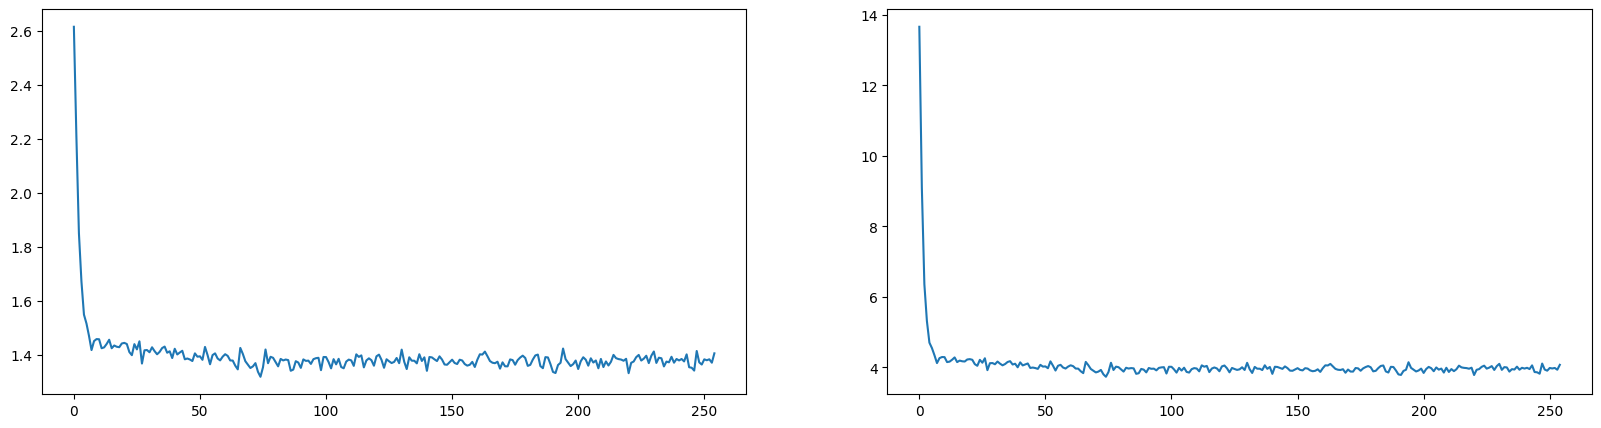

In [140]:
graph_it(net, ds=ds_train, n_batches=200, device='cuda:1')

  0%|          | 0/200 [00:00<?, ?it/s]

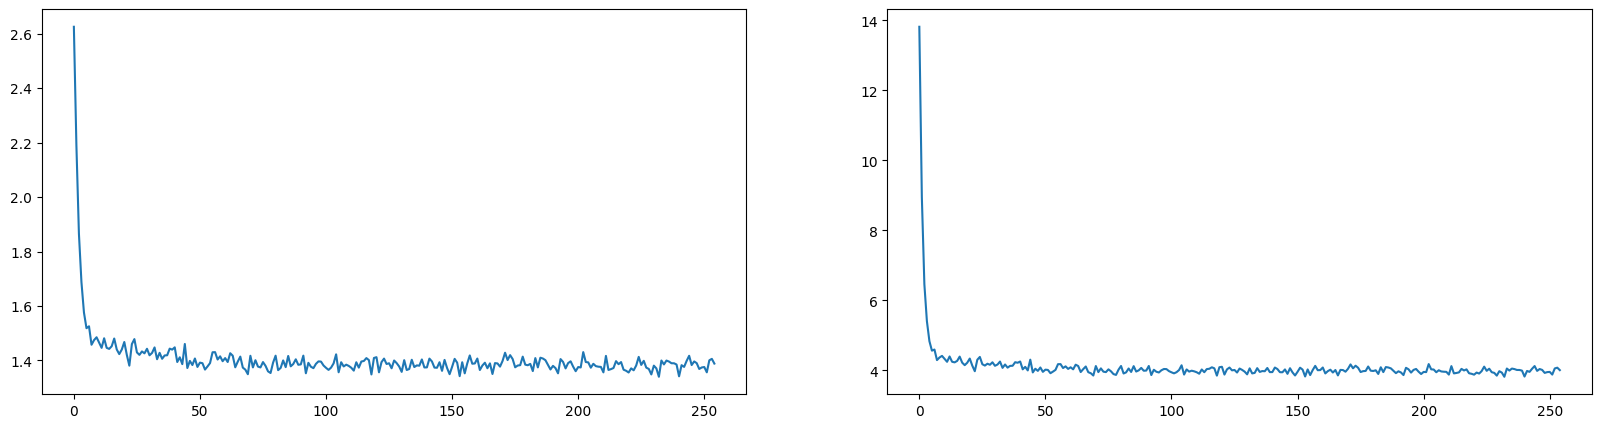

In [141]:
graph_it(net, ds=ds_test, n_batches=200, device='cuda:1')

  0%|          | 0/200 [00:00<?, ?it/s]

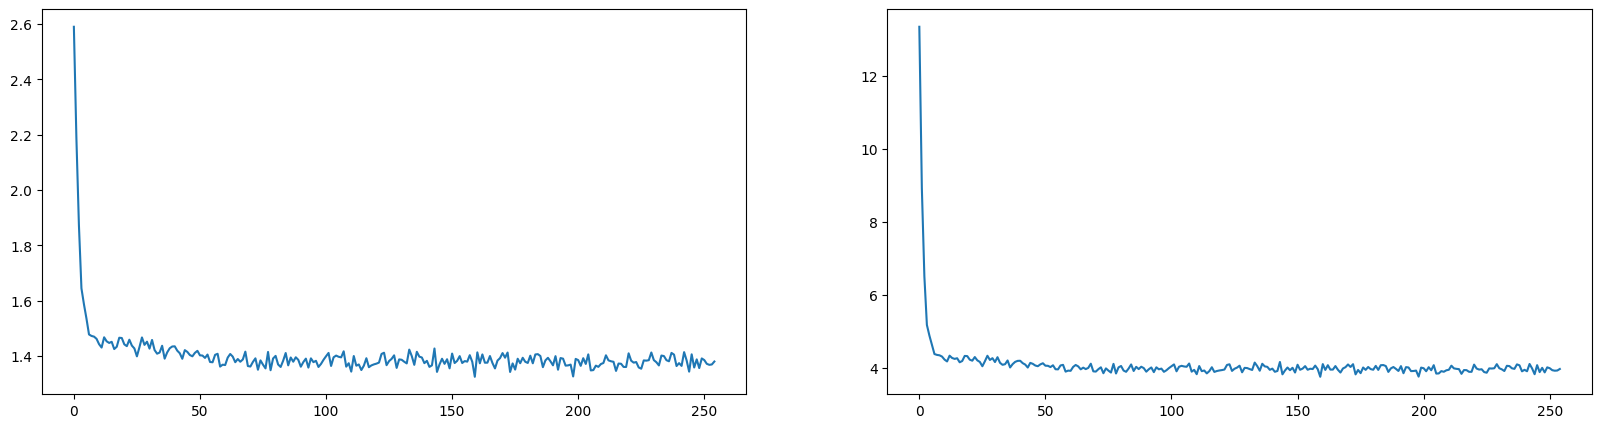

In [143]:
losses = graph_it(net, ds=ds_test, n_batches=200, device='cuda:1')

(0.0, 20.0)

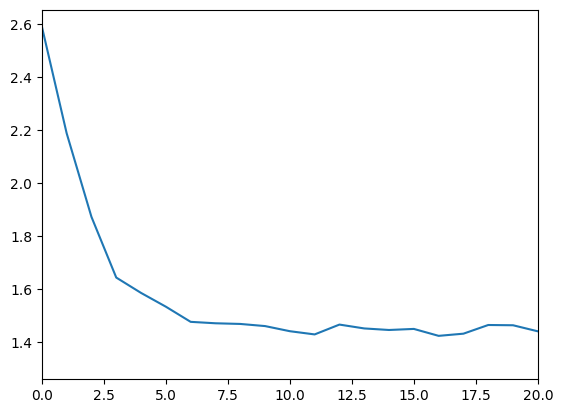

In [148]:
plt.plot(losses)
plt.xlim(0, 20)
# plt.xscale('log')

In [59]:
config_net = longrange.get_config("longrange1")
print(config_net)
net = longrange.LongRangeGPT(**config_net)
util.count_params(net)
x = torch.randint(0, 10, (1, 28))
memory = torch.randn(1, 28, 384)
logits, memory = net.forward(x, memory_in=memory, calc_memory_out=True)
# for block in net.blocks_main:
#     print(block.attn_weights.shape)
# for block in net.blocks_memory_creator:
#     print(block.attn_weights.shape)
# for block in net.blocks_memory_retriever:
#     print(block.attn_weights.shape)

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 6, 'n_head': 6, 'n_embd': 384, 'n_latent_tokens': None, 'use_memory': True, 'share_cr': False}


In [49]:
batch1, batch2 = next(dataset.get_random_skip_batches(a, 1, 128, 256))

In [52]:
longrange.loss_fn_longrange(net, batch1.long(), batch2.long())

tensor(4.9990, grad_fn=<DivBackward0>)

In [91]:
block = transformer.Block(dict(n_embd=384, n_head=1, attn_pdrop=.1, resid_pdrop=.1))

In [92]:
x = torch.randn(1, 10, 384)
y = torch.randn(1, 20, 384)
nx, ny = x.shape[-2], y.shape[-2]
mask = ~torch.tril(torch.ones(nx, ny, device=x.device), diagonal=ny-nx).to(bool)
a, b = block.attn(x, y, y, attn_mask=mask)
a.shape, b.shape

(torch.Size([1, 10, 384]), torch.Size([1, 10, 20]))

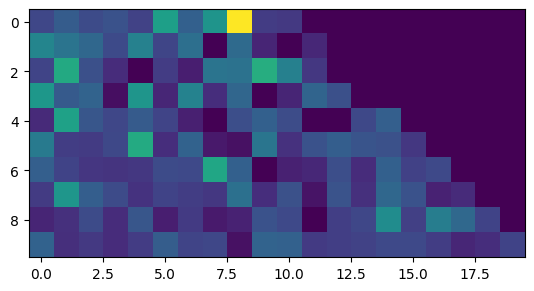

In [93]:
plt.imshow(b[0].detach().numpy())